# PSI Transmission Analysis 

see the REAMD.md for a plan of this work. <br/>
see model.py for reference to the functions used in this notebook.

In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

ModuleNotFoundError: No module named 'scipy'

According to my cursory understanding of the elog, Runs 22-34 from Dec. 8th were performed using a correct normalization technique. These are storage measurements, but the configuration is unclear. There is a config change "setup to guide 1" after 14.tof, but then "mounting the first guide" occurs after 35.tof. This remains to be resolved.

Nonetheless, we can produce a storage lifetime curve for this brief series of runs.

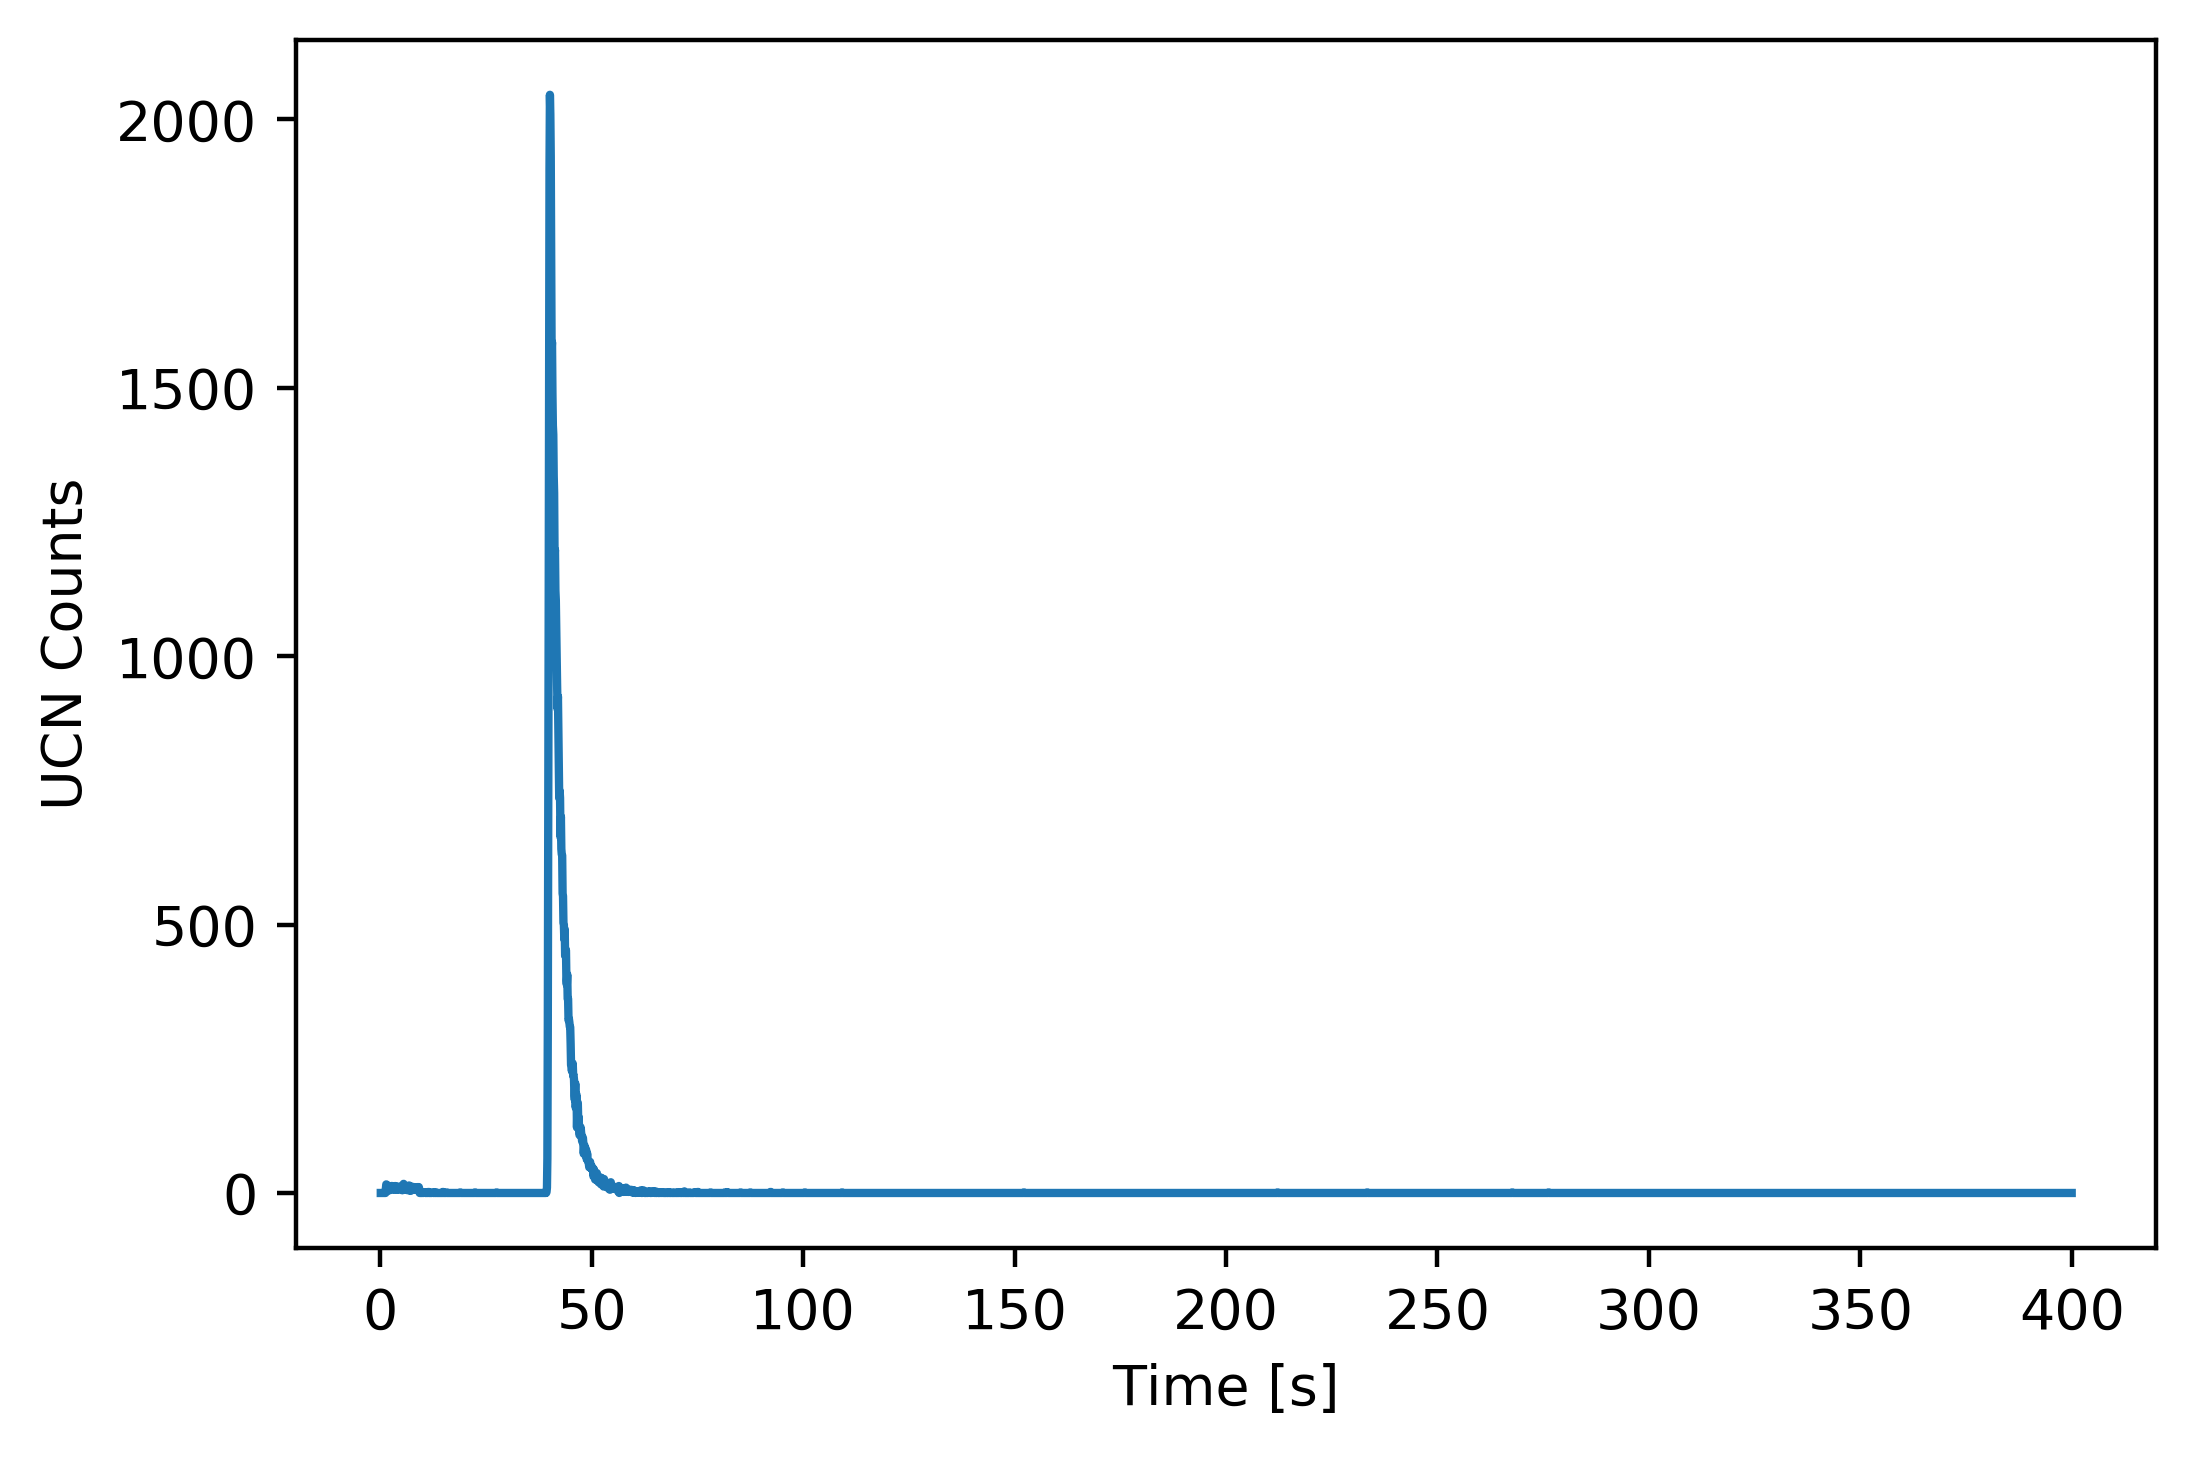

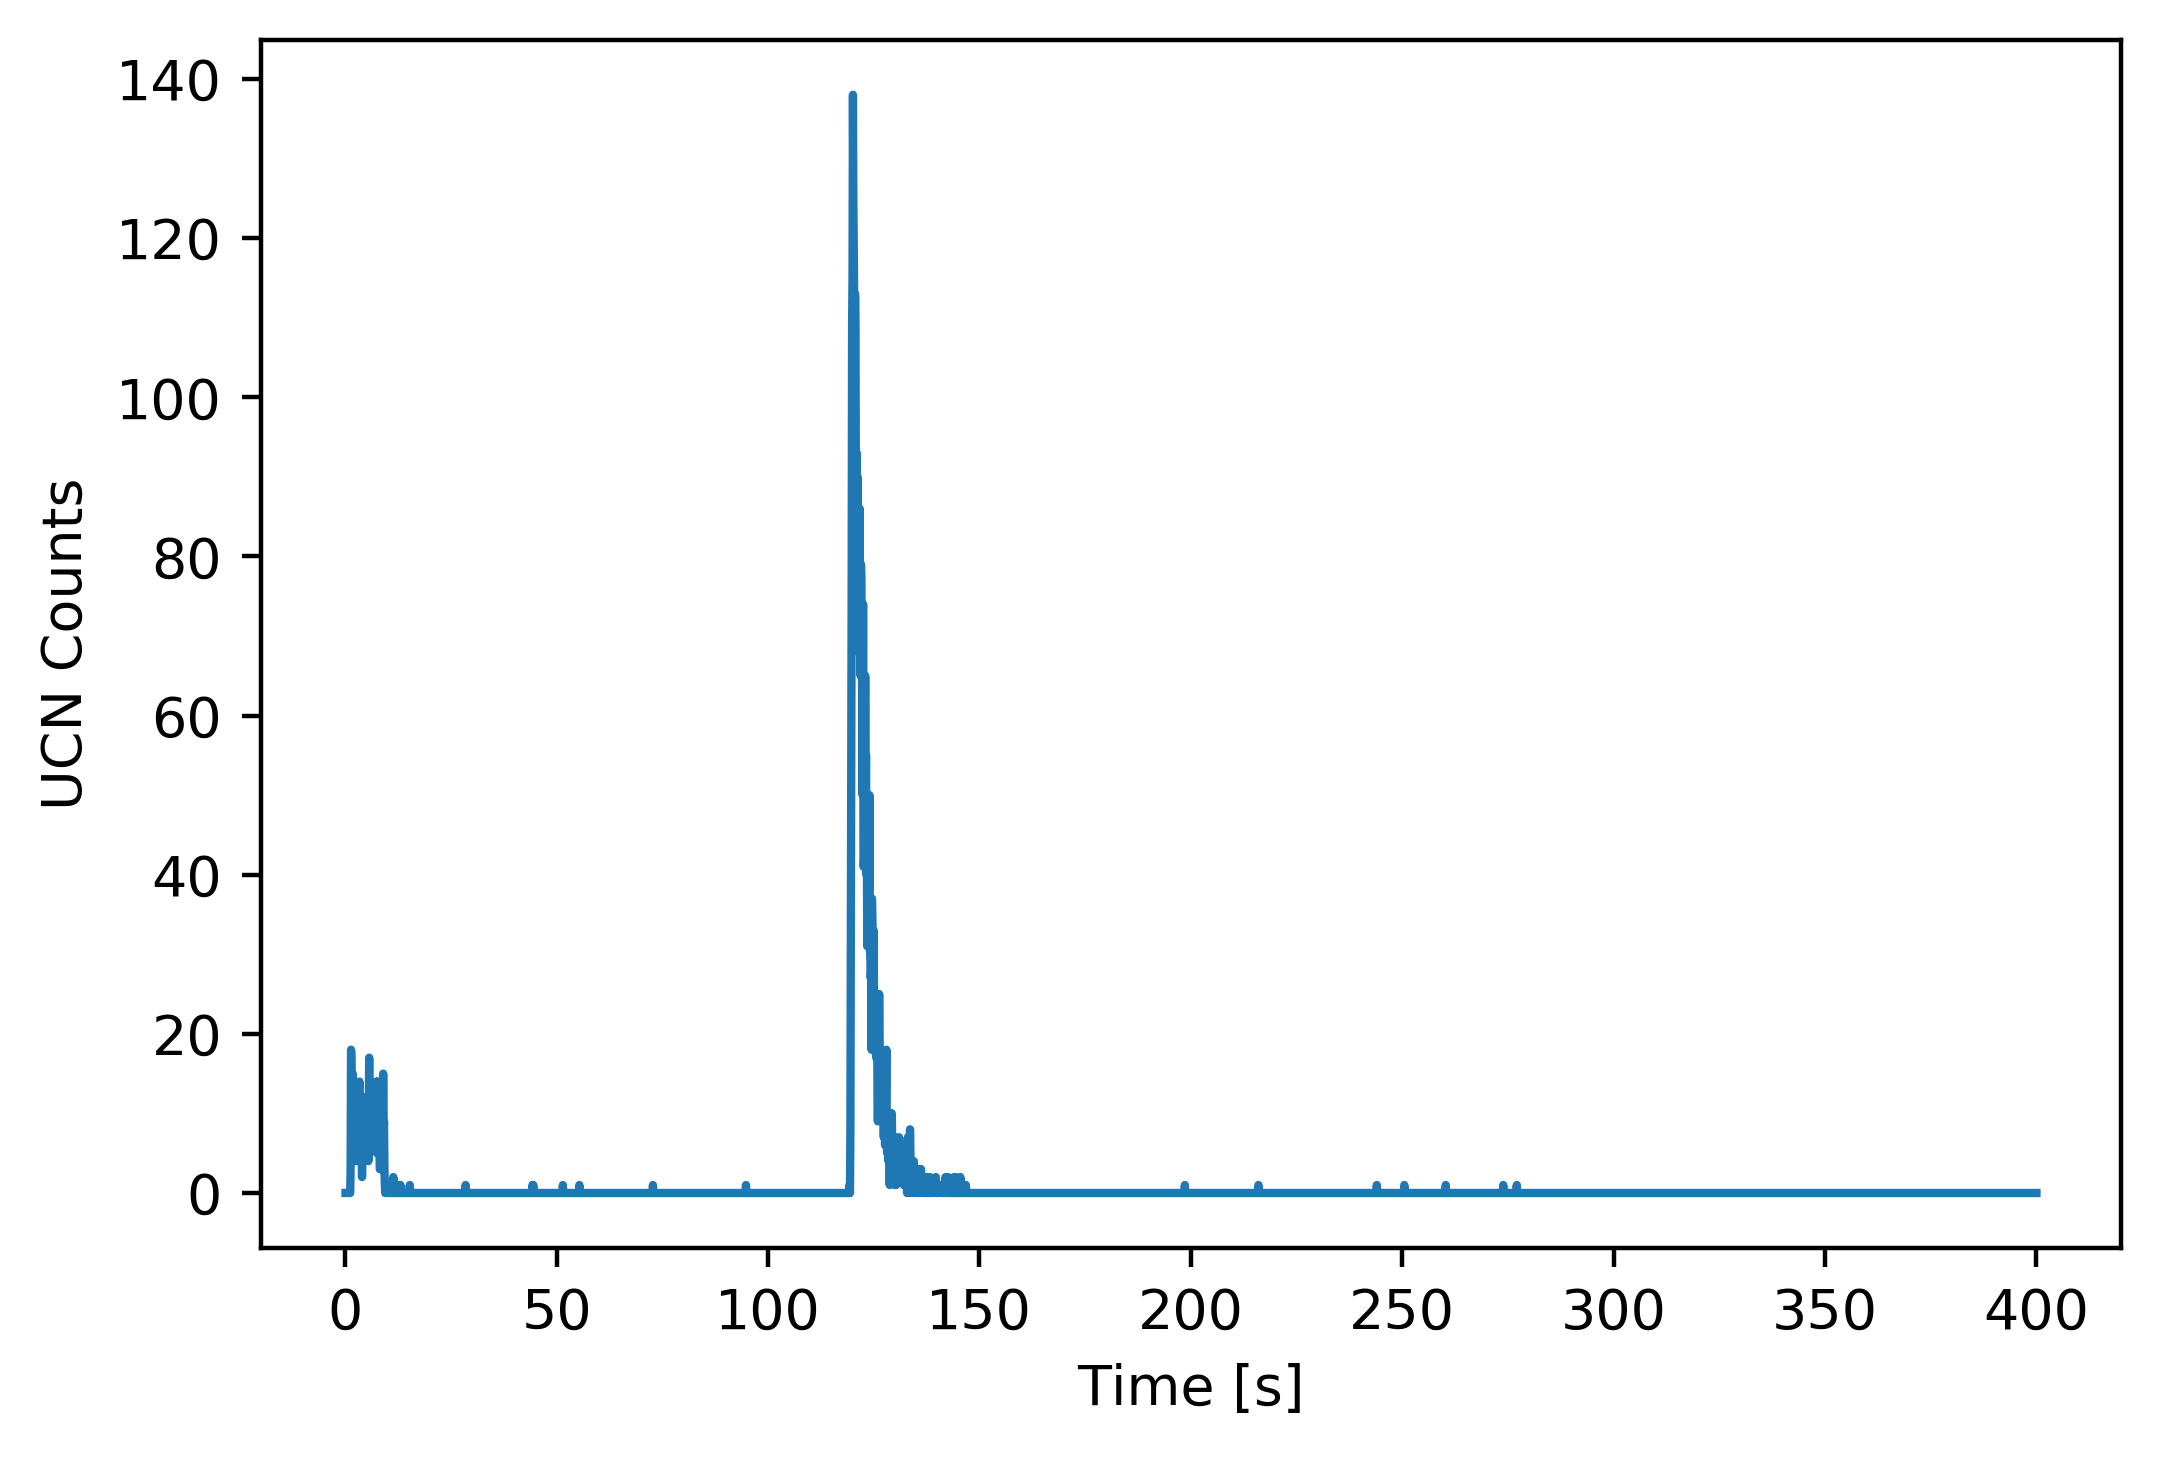

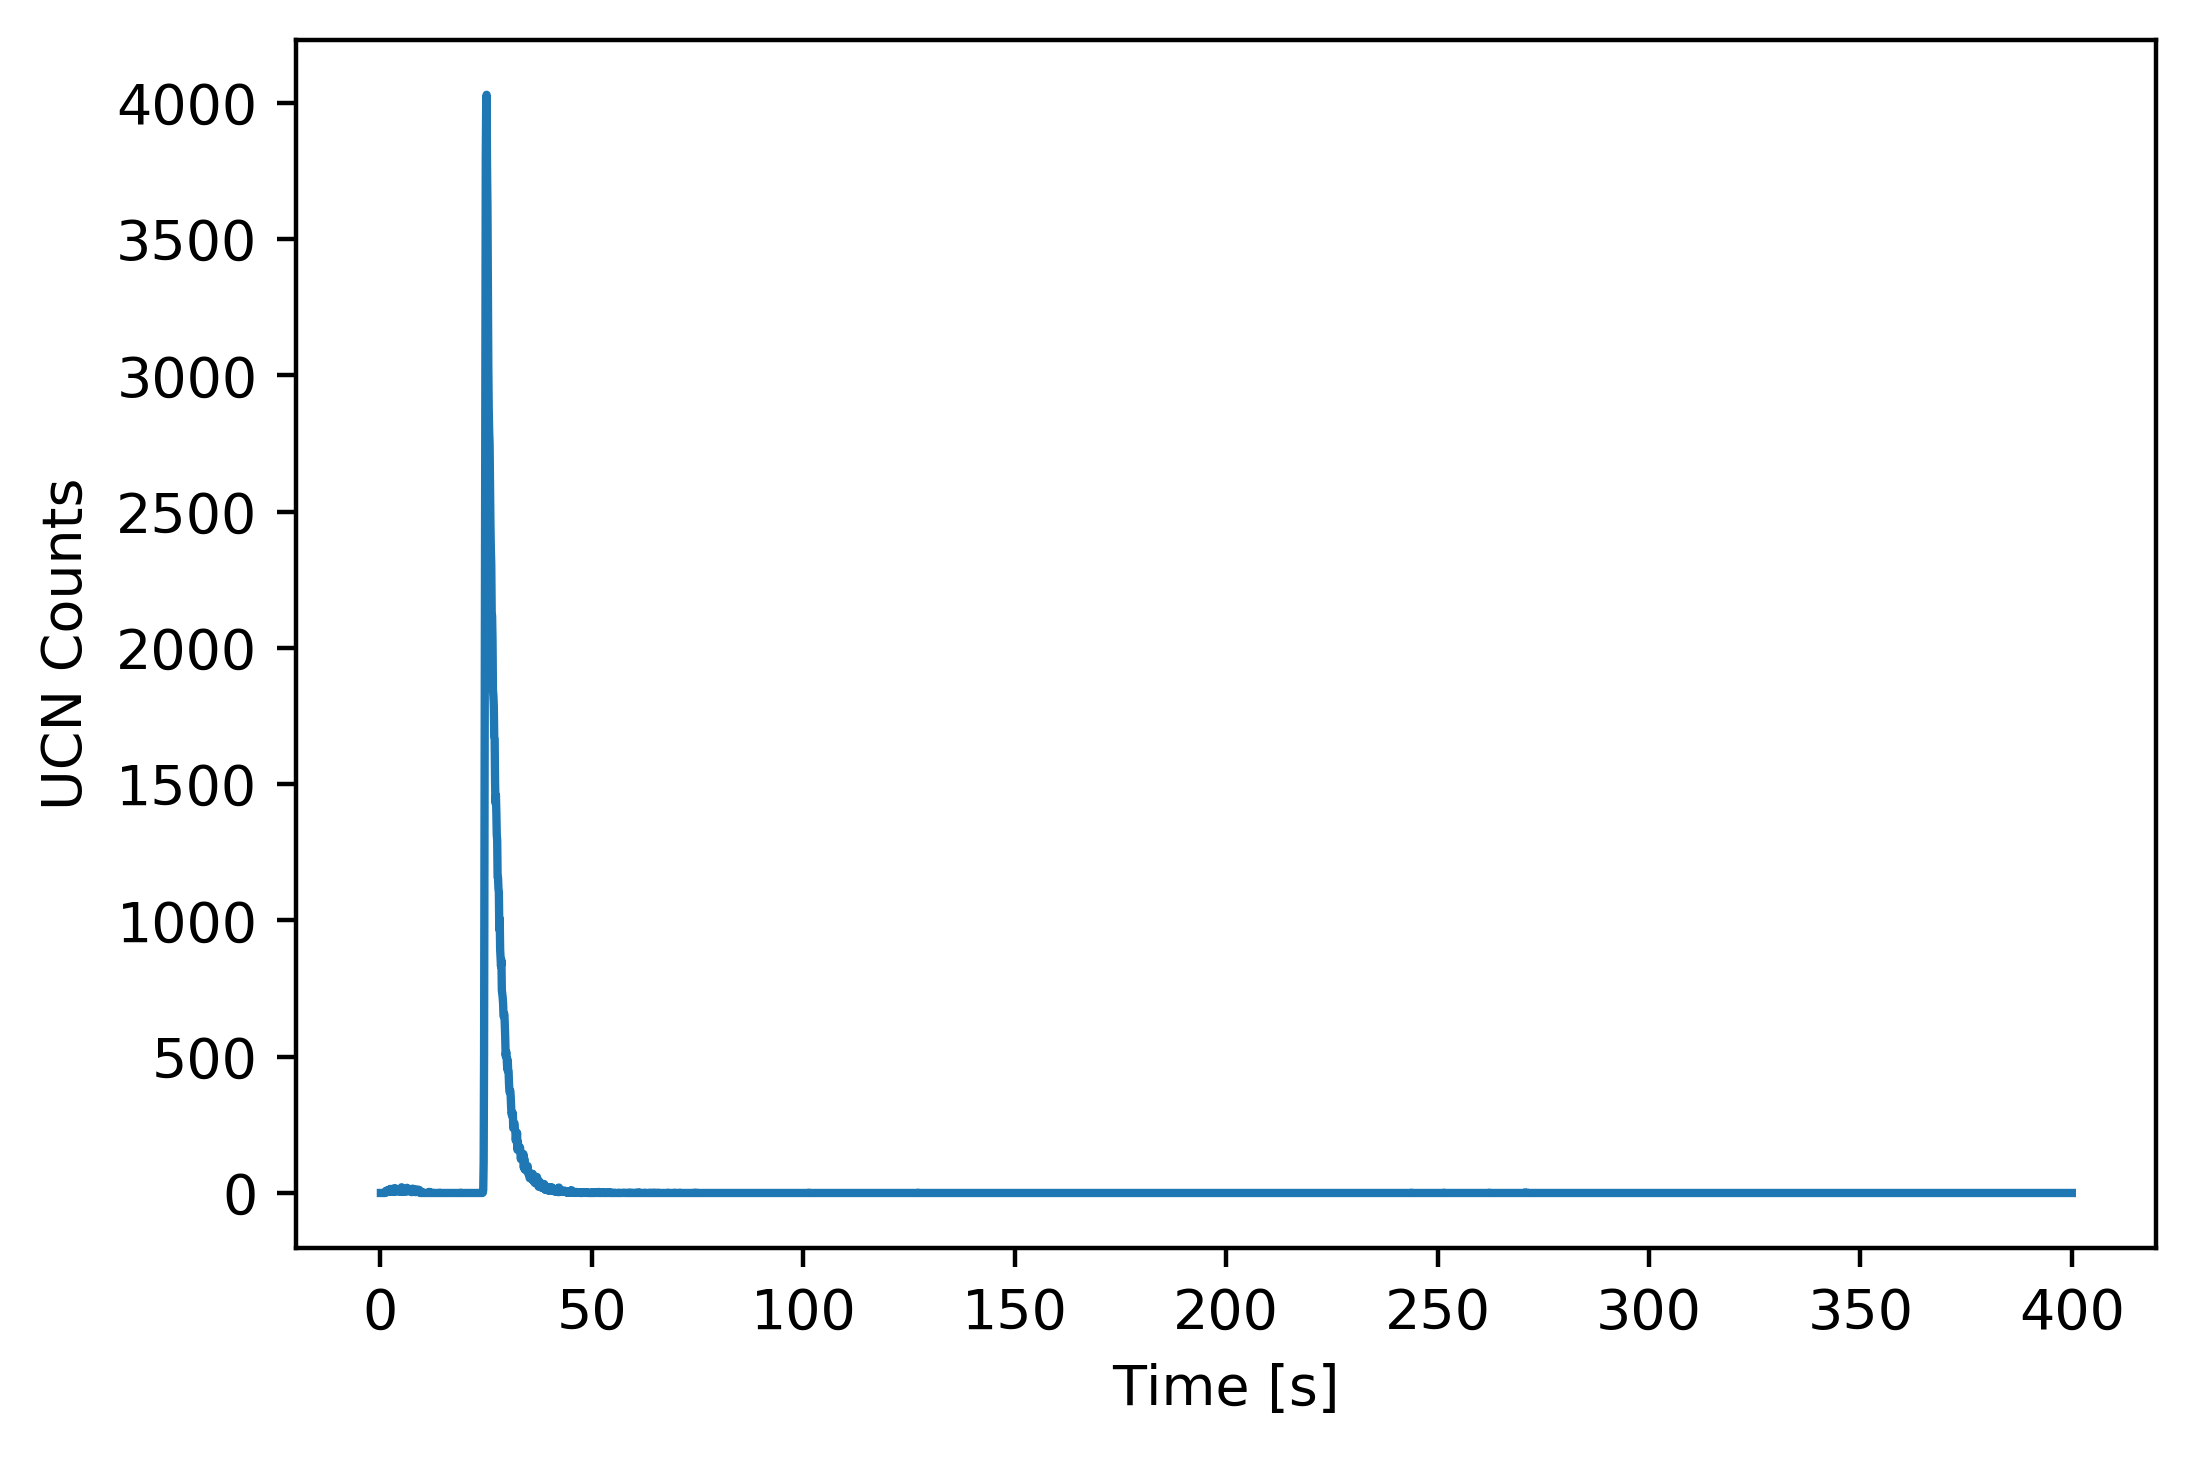

In [25]:
# Importing and plotting the 22.tof data
data = np.loadtxt("../data_main/12/8/T081217_0022.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
# plt.xlim([0,70]);
plt.show()

plt.clf()
data = np.loadtxt("../data_main/12/8/T081217_0025.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
# plt.xlim([100,200]);
plt.show()

plt.clf()
data = np.loadtxt("../data_main/12/8/T081217_0032.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
# plt.xlim([0,50]);

The above three plots show the three storage times used for the various runs in this sequence. Ruediger's recommendation was to change file names to include the relevant information for analysis. I think the naming convention will become clear when I've finished parsing the elog, so I'll return to that larger organizational task later. 

## Storage Lifetime

Important steps to this analysis include:

- Integrating counts over the main releasing window, where UCN are detected downstream. This requires selection of the right window for the right storage time used.

Fit parameters:
 N_0: 130104.863800,
 tau:   23.987842


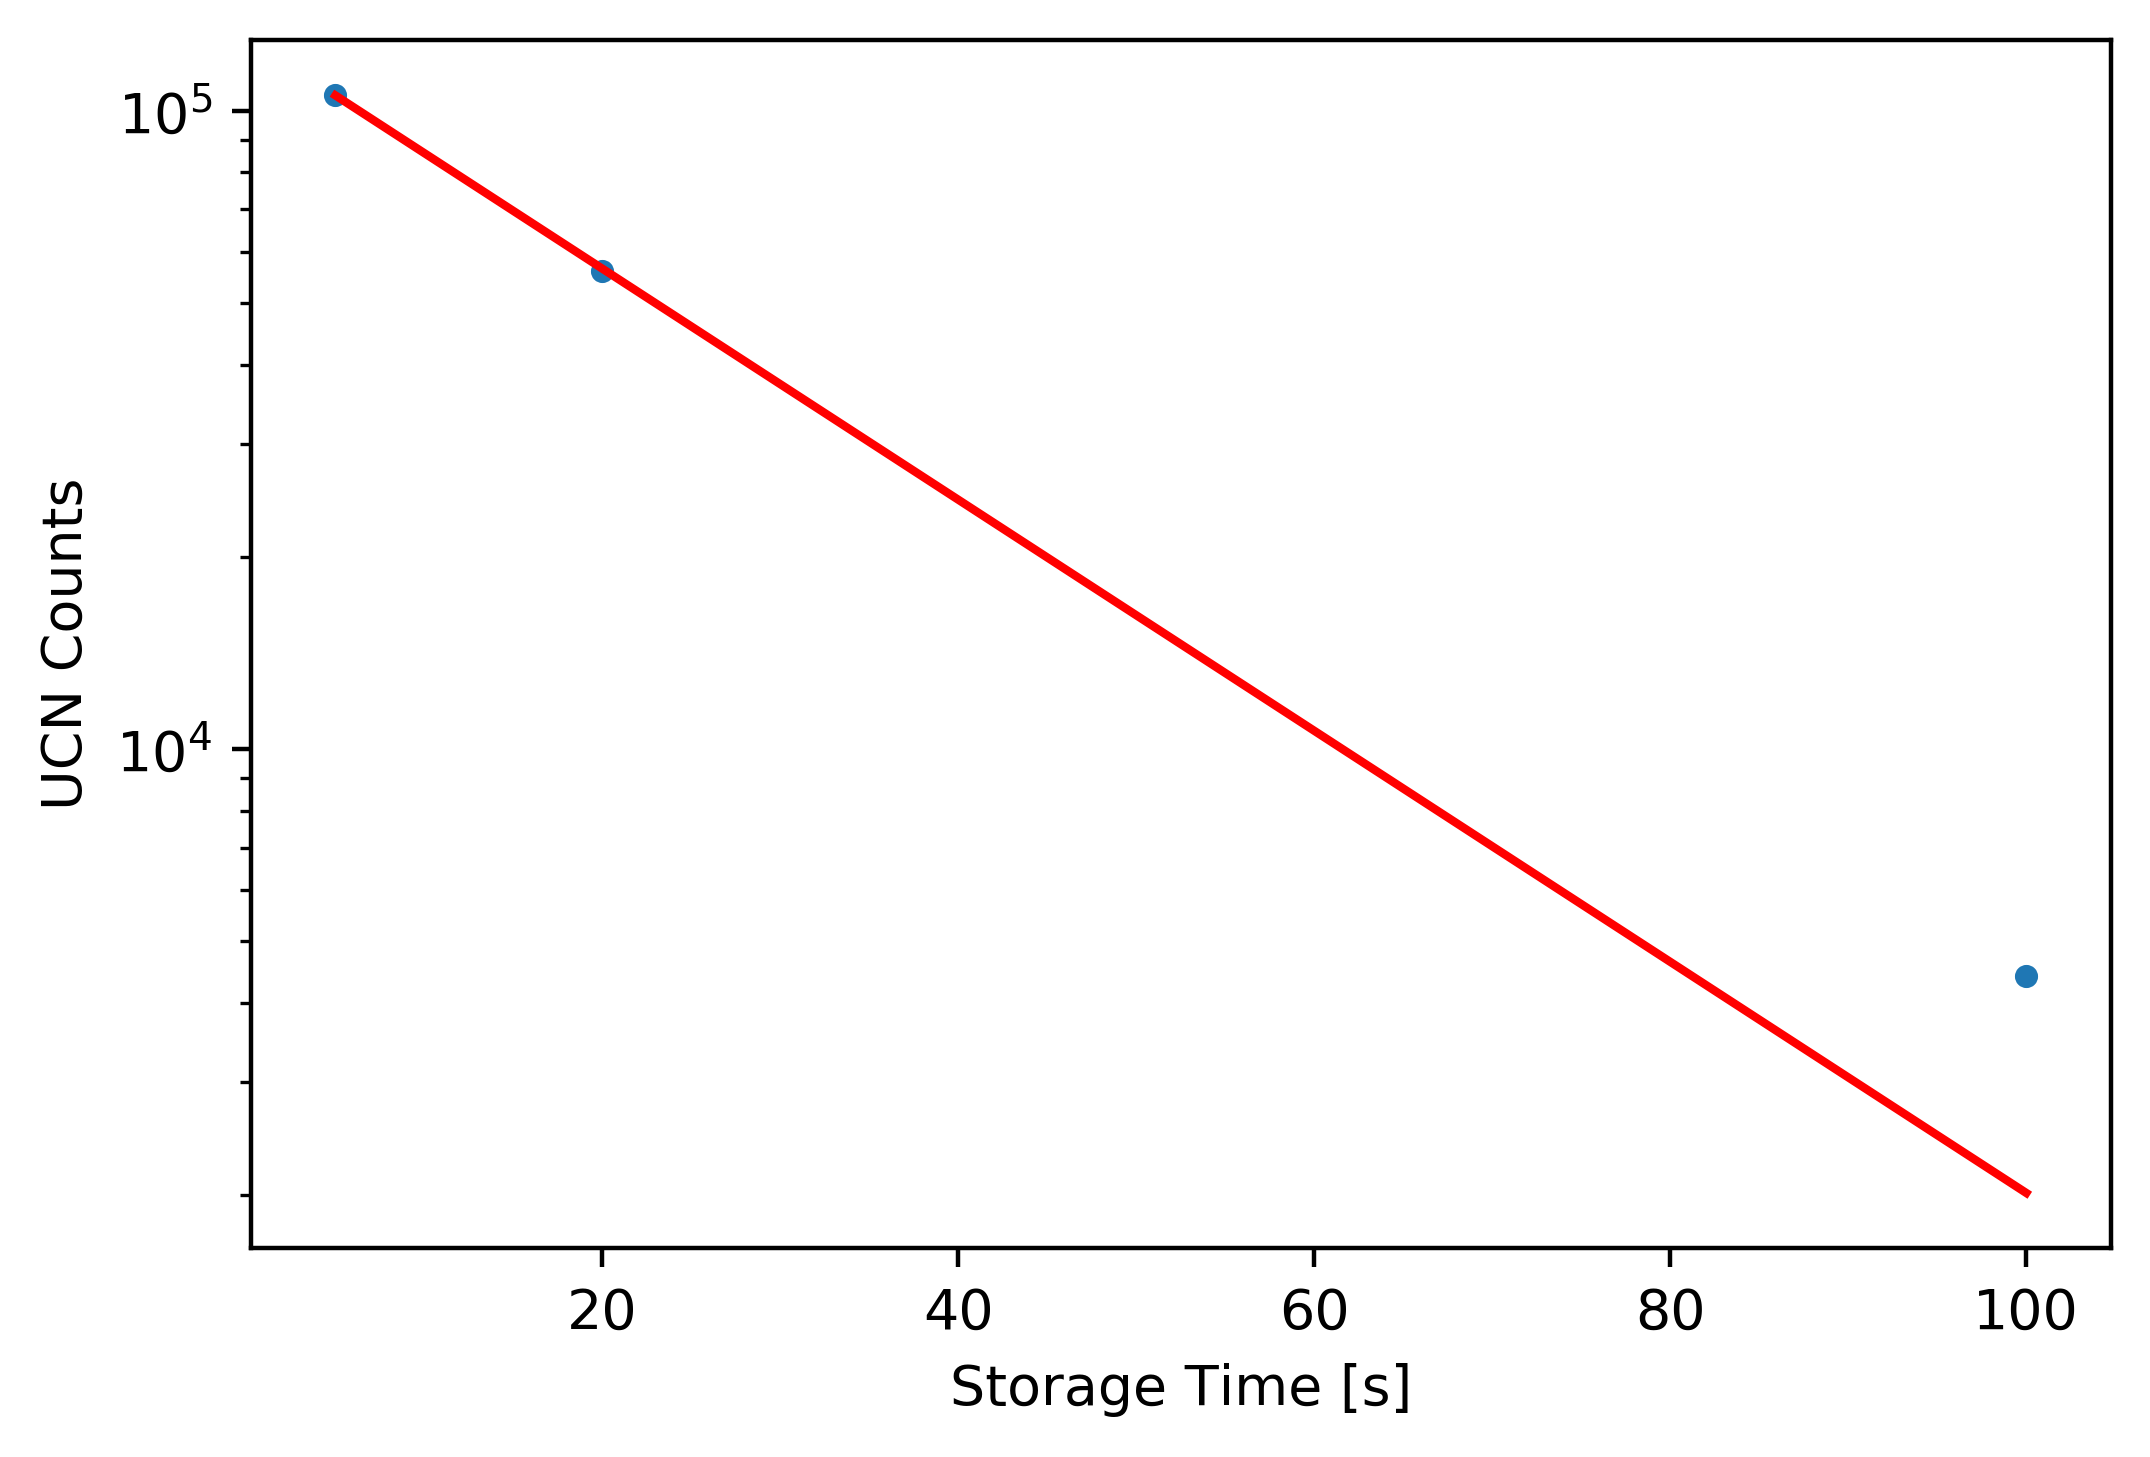

In [35]:
# load the 100 s storage time data into an array
time_s100, data_s100, monitor_data_s100 = load_data(
    [25, 26, 27, 28, 29, 30, 31], [8, 8, 8, 8, 8, 8, 8])

# load the 20 s storage time data into an array
time_s20, data_s20, monitor_data_s20 = load_data([22,23,24], [8, 8, 8])

# load the 5 s storage time data into an array
time_s5, data_s5, monitor_data_s5 = load_data([32, 33, 33, 34], [8, 8, 8, 8])

# average over many runs and integrate over run times to get proper storage counts
result = storage_integrate([data_s100, data_s20, data_s5])  

A very rough attempt at a storage lifetime calculation. 

>!!! Issue/Question<br/> Here I have integrated each run, then averaged the results for multiple runs of the same storage time to generate a single point. Is it proper to do the most straightforward statistical uncertainty calculation from the variance in this 3 or 4 (8 in the case of 100 s storage) run averaging?</mark>

>!!! Issue/Question<br/> My choosing of the integration window is entirely eye-balled based on where the downstream valve appears to have been opened. Does it really matter? A systematic approach might be to perform some sort of automatic fitting routine and then use that to choose an integration time window. This seems like overkill since the background calibration appears to already be extremely good.</mark>

## Measuring Source Degradation

The source performance decayed over time during the experimental run. 

>!!! Issue/Question<br/> My first approach here will be to use the direct shot measurements as a measure of source performance. The assumption is that direct shot's are less sensitive to material properties of the guides, and thus provide a close enough approximation to a UCN production measurement? Is this valid? It's not clear from Edgard's slides how he produced the "UCN yield variation" plot on slide 12 of note_PSI_Data_feb2019.pdf.</mark>

One reason why I'm quite skeptical of this, is that the elog suggests that storage measurements were deliberately taken for this purpose:

>[Mon, Dec 11, 2017, 13:07:58 ]  check some data in order to estimate any possible decrease of the UCN yield over time.

Here is a list of all the direct shot runs, and their (not yet confirmed) configurations:

Run #   | Day |  Configuration             |
---     | --- |  ---                       |
48      | 8   |  JP SUS guide with NiP     |
76      | 8   |  No Guide?                 |
98      | 8   |  JP Ti guide with NiP      |
120     | 9   |  Unclear?                  |
145     | 9   |  SS Disk                   |
175     | 9   |  Two flanges               |
120     | 9   |  Unclear?                  |
198     | 9   |  UGD01                     |
122     | 10  |  Two flanges               |
145     | 10  |  UGD03                     |
170     | 10  |  Two flanges               |
193     | 10  |  EP SUS guide with NiP     |
194     | 10  |  EP SUS guide with NiP     |
249     | 10  |  Two flanges               |
273     | 10  |  2 x 30 Plexiglass guides  |
274     | 10  |  2 x 30 Plexiglass guides  |

My present thinking is that the "Two flanges" configuration is for normalization, and we should be looking at just these runs for source degradation over time.

Fit parameters:
 N_0 = 4118305.8973583397 +/- 81925.00239329379,
 A: -7.383987956655107 +/- 0.47920028739319


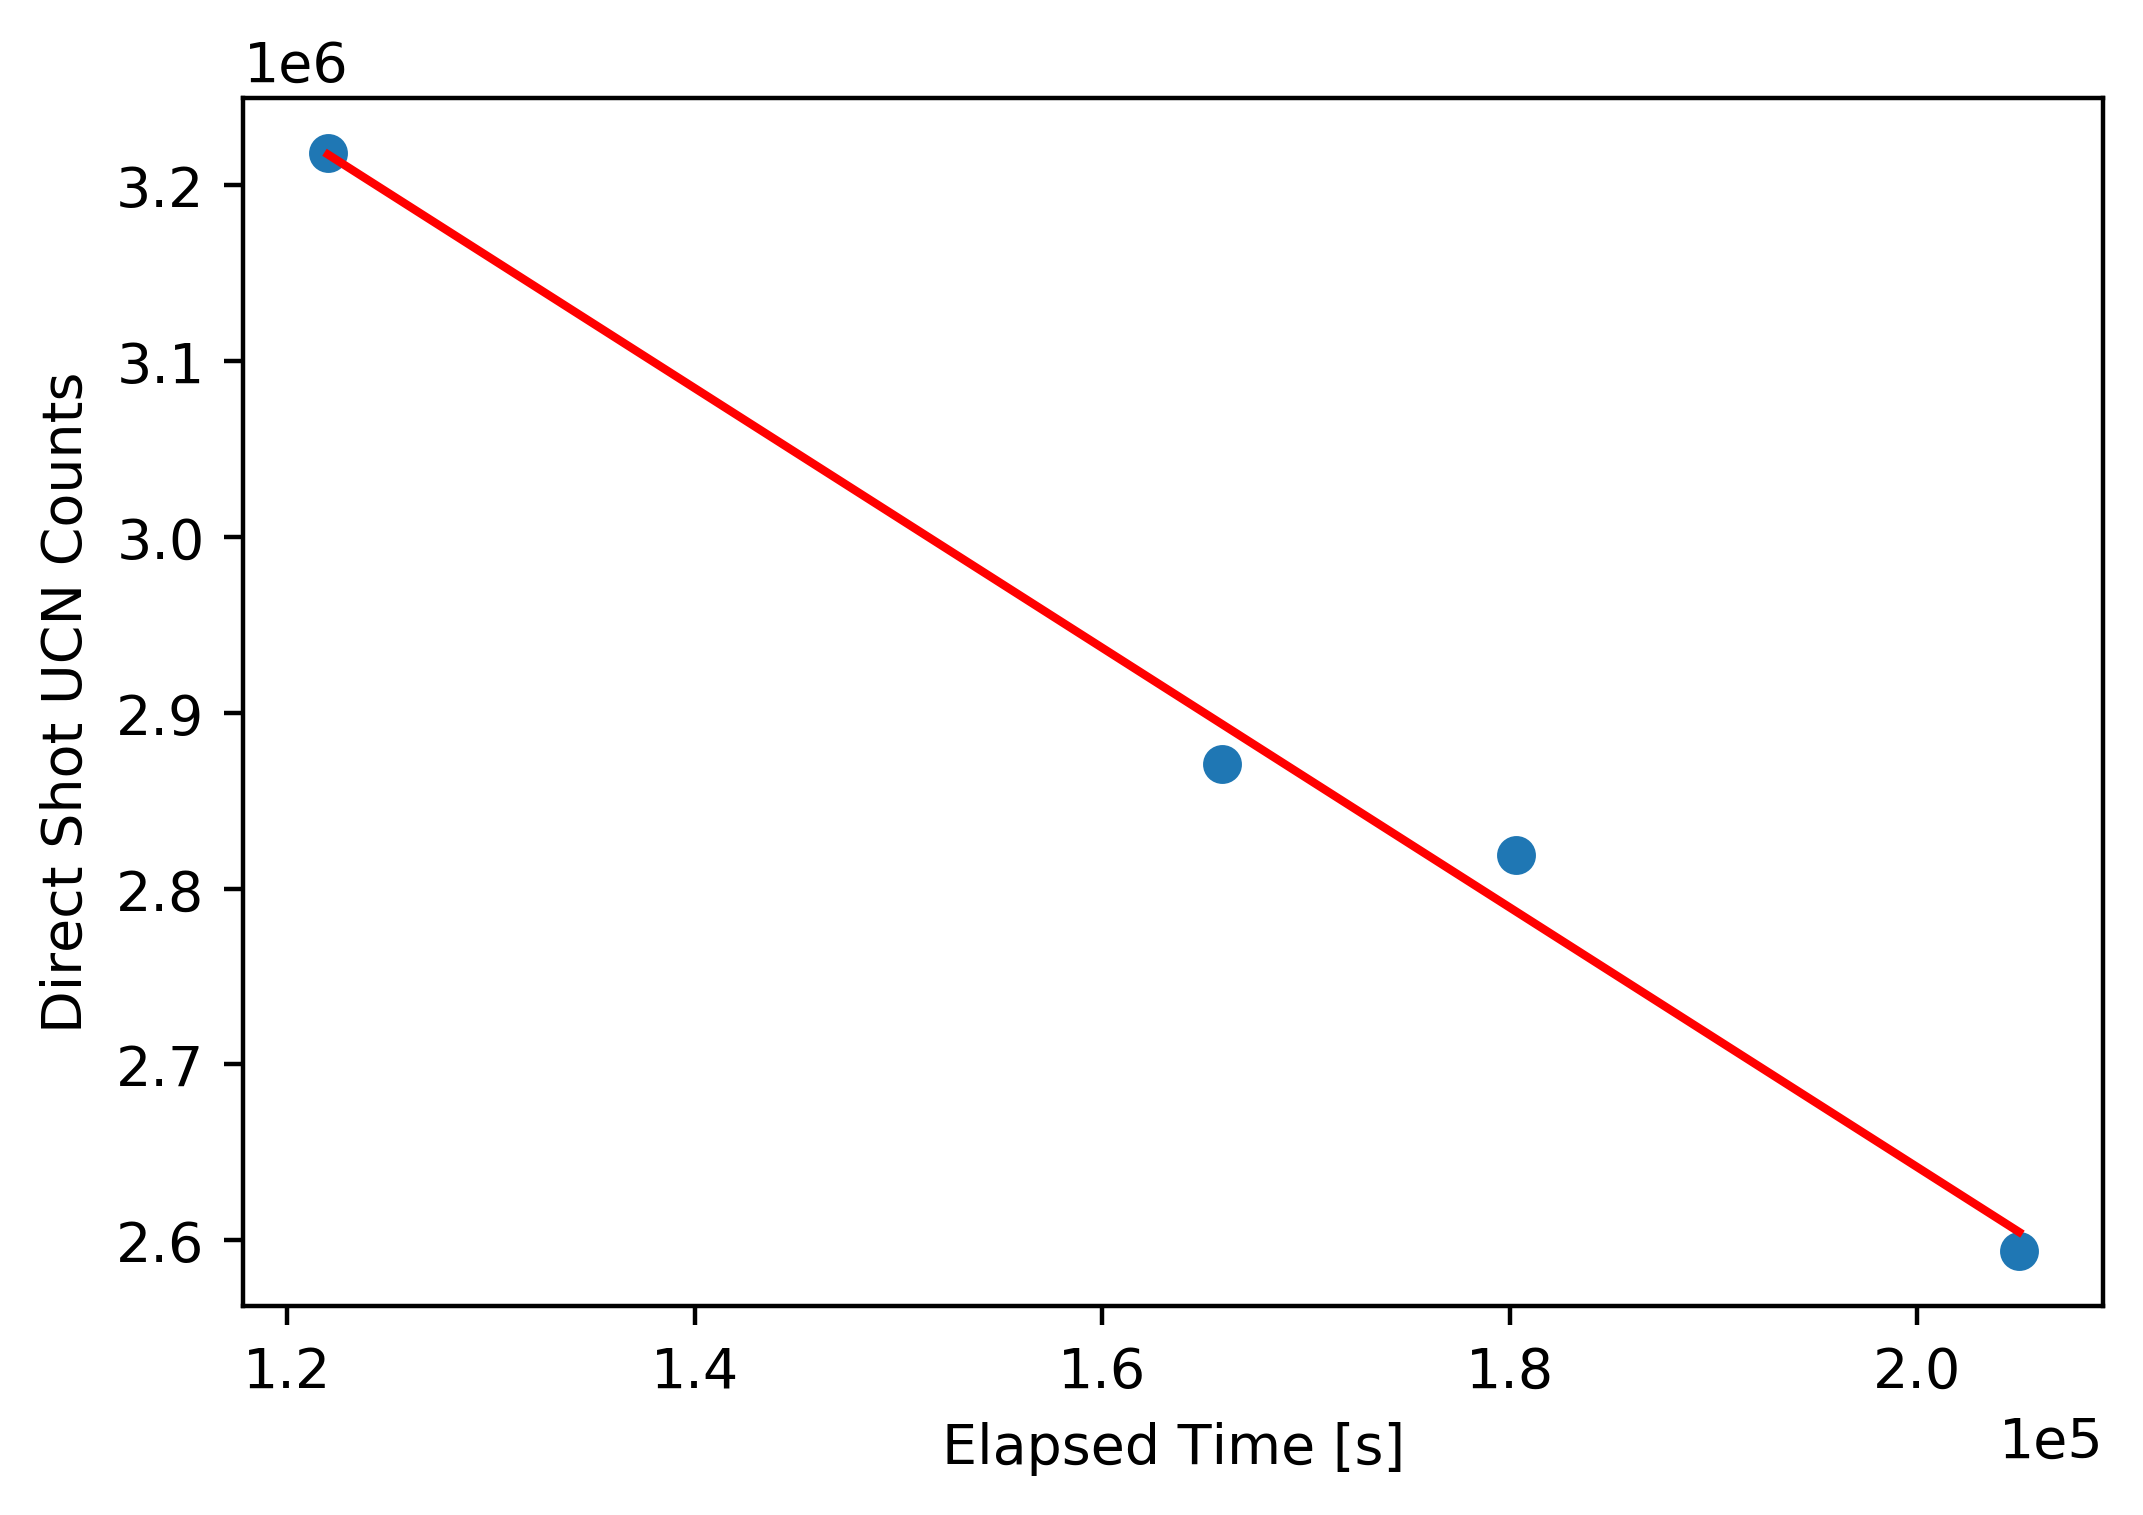

In [29]:
# lists of all the runs, and their corresponding days, which were direct shot measurements
run_list = [175, 122, 170, 249]
day_list = [  9,  10,  10,  10]

# the above lists are hard-coded into this function, which we can return to and change if this calculation needs to 
# be adjusted.
times, result, fit_parameters = UCN_yield(plotting_flag = True)

In [32]:
type(run_list)

list

The general position of these four data points, and the trend, seems to agree with what Edgard has produced on page 12 of his slides. The values themselves are off, but this could just have something to do with how he calculates integrated counts. 

To use this result in normalization of other runs, we need to interpolate on this curve.

In order to repackage this result into a normalization on all measurements, we simply interpolate on this fit using the start time of a particular run. I've performed this normalization routine on all the data, so it occurs in the load_data function when the un-integrated count data is first imported.

> !!! Issue/Question<br/>
I haven't added normalization of the monitor count data yet, but presumably this will need to be done, with a separate fit to be performed and used for interpolation.

> !!! Issue/Question<br/>
There's no statistical uncertainty on these data points, because they are coming from single run direct shots. Since this is used in calibration it doesn't seem like a concern? Is that right?

## Transmission

Since we have counts from a monitor detector, this will likely be relied on for transmission analysis of the various guides. However, on slide 8 of note_PSI_Data_feb2019.pdf, Edgard notes that guide transmission can be calculated from:

>Ratio of peaks integral w/wo guide gives the transmission.

The plot on the referenced slide is of a 20s storage measurement. It's important that transmission is calculated by the comparison of runs with the same storage time. However, I see no reason why we wouldn't be able to use 5, 20, or 100 second runs, as long as we're consistent with what were comparing. In fact wouldn't we gain additional statistical sensitivity by performing the analysis on all three data sets?

> !!! Issue/Question <br/>
I'm not sure what I'm doing here generally, but I'll try to proceed in a way that is somehow agnostic towards possible changes in the analysis method.

There are many outstanding questions regarding the configuration order, so this proof of concept will use the following normalization and guide runs:

Run #'s    | Day |  Storage Time (s)   | Configuration |
---        | --- |      ---            | ---           |
123 - 130  | 10  |      100            | Two flanges   |
131 - 133  | 10  |       20            | Two flanges   |
134 - 136  | 10  |        5            | Two flanges   |
146 - 155  | 10  |      100            | UGD03         |
156 - 158  | 10  |       20            | UGD03         |
159 - 161  | 10  |        5            | UGD03         |


In [ ]:
# run lists for UGD03 and immediately preceding normalization runs
run_list_n100 = [123, 124, 125, 126, 127, 128, 129, 130]
run_list_n20 = [131, 132, 133]
run_list_n5 = [134, 135, 136] 

run_list_g100 = [146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
run_list_g20 = [156, 157, 158]
run_list_g5 = [159, 160, 161]

day_list_n100 = [10, 10, 10, 10, 10, 10, 10, 10]
day_list_n20 = [10, 10, 10]
day_list_n5 = [10, 10, 10]

day_list_g100 = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
day_list_g20 = [10, 10, 10]
day_list_g5 = [10, 10, 10]

run_list = [run_list_n100, run_list_n20, run_list_n5, run_list_g100, run_list_g20, run_list_g5, 
           day_list_n100, day_list_n20, day_list_n5, day_list_g100, day_list_g20, day_list_g5]
                       
storage_times, transmission_result = transmission(run_list)
transmission_result

It's surprising that the 100s storage time data yields a higher transmission ratio than the 20 or the 5 second data. Also if these results are compared to Edgard's, they don't agree, so perhaps there's some misstep. However, it's not clear that he has renormalized all his results based on source performance degradation, whereas I have. It could explain the discrepancy. 

## Augmenting the Analysis with PENTrack Simulation results

In the orithyia_data/jberean2/prestorage_sims folder there are scripts and results from PENTrack simulations performed for use in this analysis. Our goal with these results is to determine the imaginary fermi potential.

>!!! Issue/Question <br/>
We have to perform more simulations where we continuously tune the fermi potential until the transmission results agree with the experimental analysis results. Right? I'll want to confirm my existing analysis is OK before proceeding here then.

## Rough Workspace

In [19]:
np.zeros((3,1))

array([[0.],
       [0.],
       [0.]])

In [20]:
print("a"
      "multi line"
      "string of %d"
      "and %d" % (2,2))

amulti linestring of 2and 2


In [8]:
name = 3.148171653
print('Hello, {}'.format(name))

Hello, 3.148171653


In [6]:
f = open("../data_main/12/8/T081217_0004.txt")
lines = f.readlines()
f.close()

In [10]:


yield_normalization(80,8)

KeyboardInterrupt: 